## This notebook contains a code which aims at building a multilinear regression model for Bitcoin price. The independent variables are as follows:
- WTI oil price [USD]
- SP500 index value
- Gold price
- Number of bitcoin transactions
- Volume of Bitcoin on the Coinbase market
- M2 money supply in the USA

###  The main idea behind this model was to check if it is worth to build a linear regression model connected with market assets. The author is aware that many other factors could be taken into account.

### Loading the dataset. The dataset is created by the author, more details can be found in the raw_data folder.

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot

In [24]:
data=pd.read_csv('BTC_regression_data.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')

### Bitcoin was not a popular asset until 2017. To operate on more reliable data "data2" dataframe was created which only contains  _01.2017 - 04.2020_ period

In [25]:
data.head()
data2=data.copy()
date_mask = data2.index < pd.to_datetime('2017-01-01')
data2.drop(index=data2[date_mask].index,inplace=True)

### Price changes in time

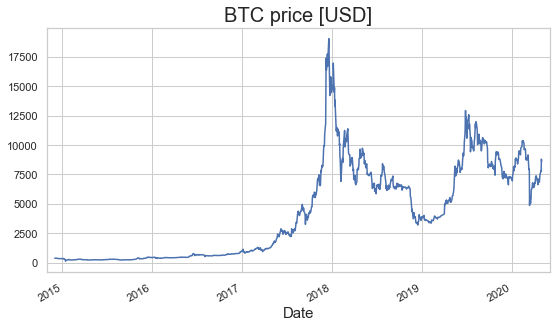

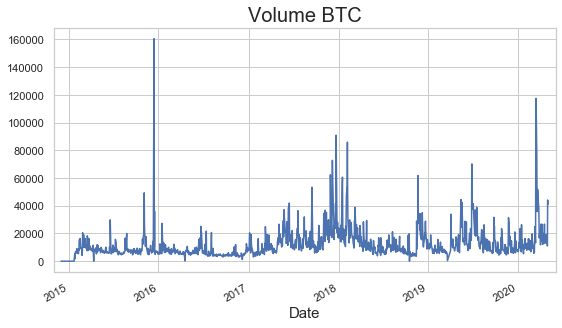

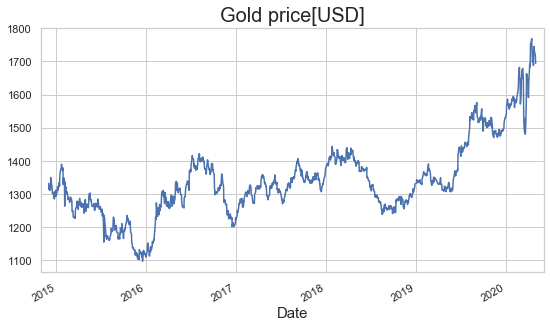

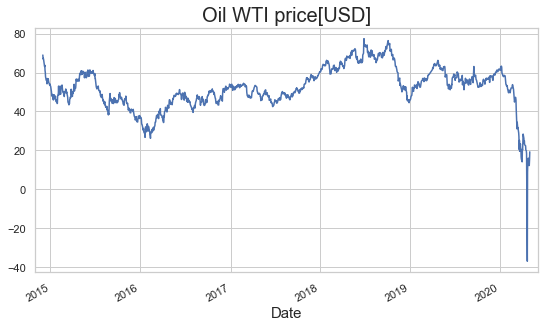

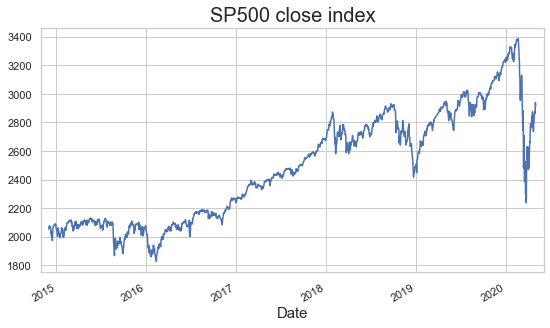

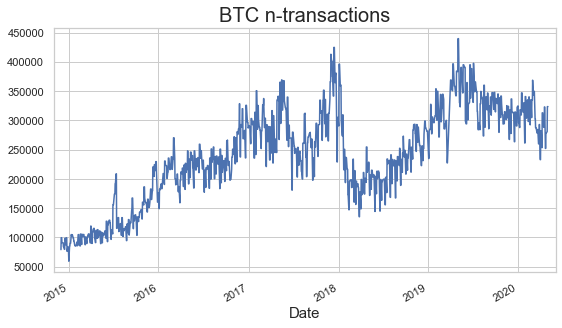

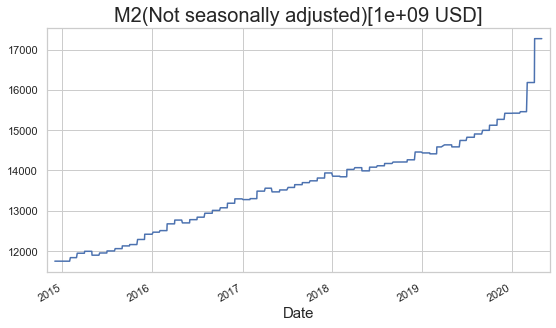

In [26]:
%matplotlib inline

datemin = datetime.date(data.index.min().year, data.index.min().month - 1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 2, 1)
sns.set(style="whitegrid", color_codes=True)

for i in data.columns:

    fig,ax = plt.subplots(figsize=(9,5))      
    data[i].plot(ax=ax)
    plt.gcf().autofmt_xdate()
    ax.set_title(i,fontsize=20)
    ax.set_xlabel('Date',fontsize=15)
    ax.set_xlim([datemin,datemax])
    plt.show()

### Graphical examination of the association between Bitcoin price and the other features

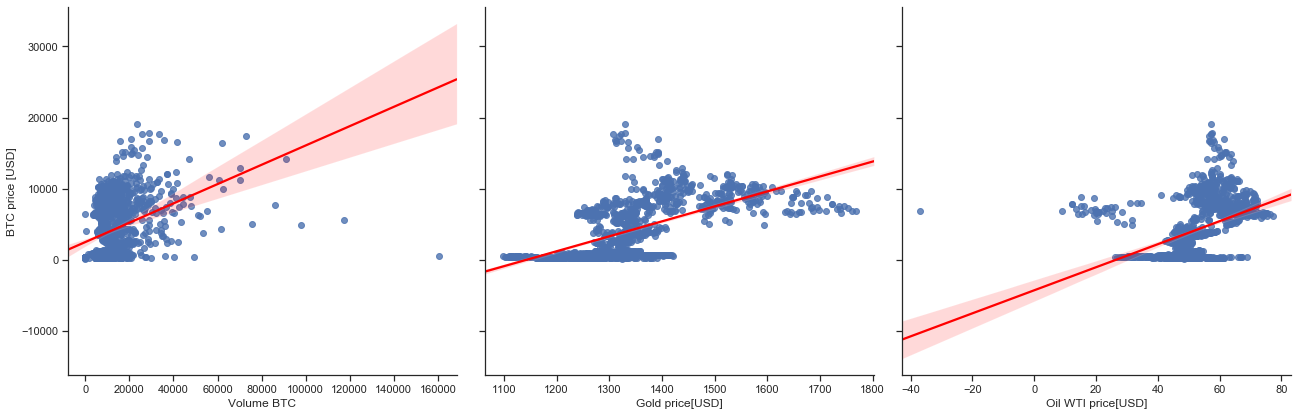

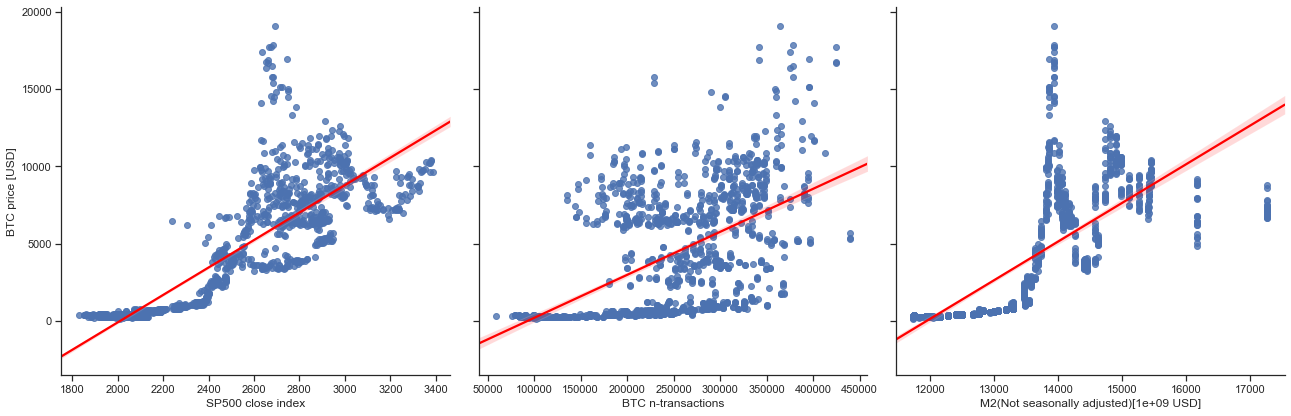

In [27]:
sns.set(style="ticks", color_codes=True)
for i in range(1,len(data.columns),3):
    g = sns.PairGrid(data,y_vars='BTC price [USD]',x_vars=data.columns[i:i+3],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})

### Some outliers are noticable in the plots. Negative WTI oil price in 2020 was a very unusual occurrence. Additionally one outlier appears in BTC price - Volume BTC plot. These values are removed. 

In [28]:
data2.drop(index=data2[data2['Volume BTC']>90000].index,inplace=True)
data2.drop(index=data2[data2['Oil WTI price[USD]']<0].index,inplace=True)

### Graphical examination of the association between Bitcoin price and the other features - without outliers and for _2017-2020_ 

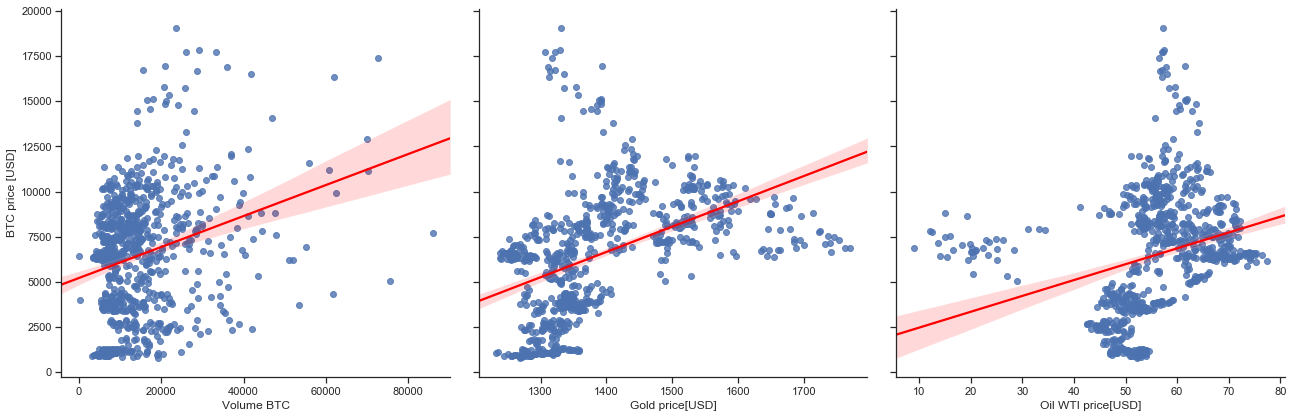

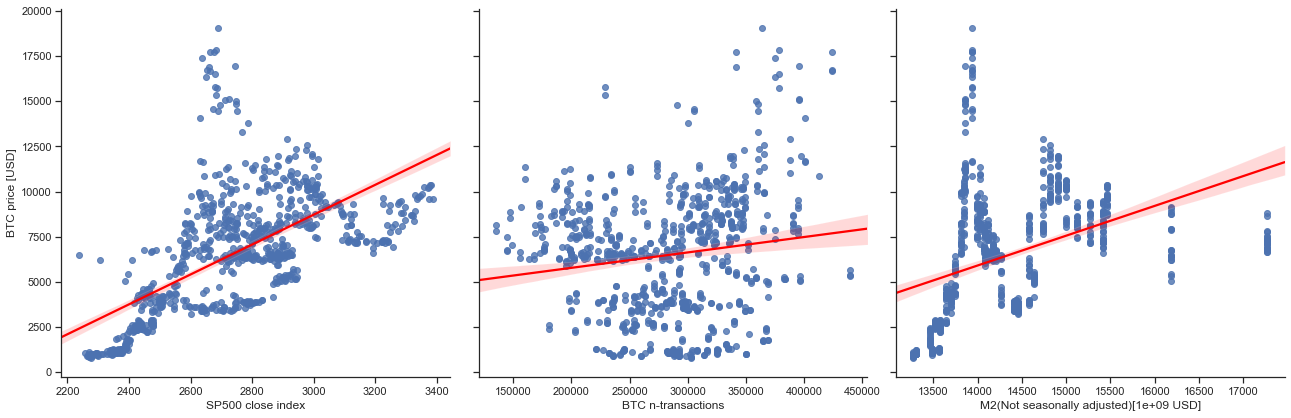

In [29]:
for i in range(1,len(data2.columns),3):
    g = sns.PairGrid(data2,y_vars='BTC price [USD]',x_vars=data2.columns[i:i+3],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})

### In order to obtain more linear data the natural logarithm of the _data2_ dataframe is taken - _data2_log_ dataframe

In [30]:
data2_log=pd.DataFrame(columns=data2.columns,index=data2.index)
data2_log=np.log(data2)
data2_log.replace([-np.inf,np.inf],np.nan,inplace=True)
data2_log.dropna(axis=0,how='any',inplace=True)
data2_log.drop(index=data2_log[data2_log['Volume BTC']<7.5].index,inplace=True)
data2_log.head()

C:\Users\Bonias\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


,BTC price [USD],Volume BTC,Gold price[USD],Oil WTI price[USD],SP500 close index,BTC n-transactions,M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,
2017-01-03,6.942340,8.983479,7.117124,3.958143,7.722159,12.580910,9.493691
2017-01-04,7.032624,9.707376,7.119069,3.975186,7.727865,12.580910,9.493691
2017-01-05,6.902793,9.924913,7.131139,3.984716,7.727094,12.572454,9.493691
2017-01-06,6.796746,9.557070,7.126007,3.988614,7.730605,12.572454,9.493691
2017-01-09,6.808388,8.692832,7.135528,3.950282,7.727050,12.468825,9.493691


### Graphical examination of the association between Bitcoin price and the other features - without outliers and for _2017-2020_ - log scale

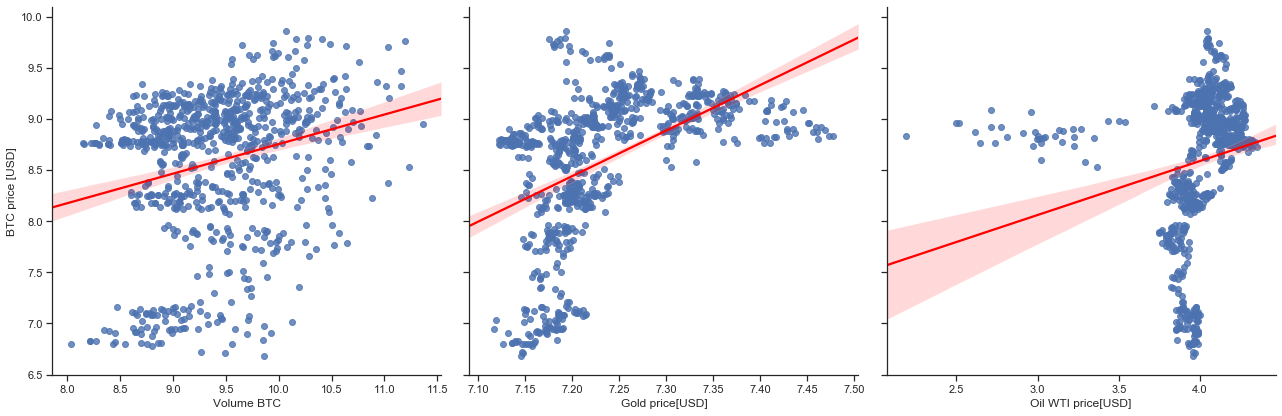

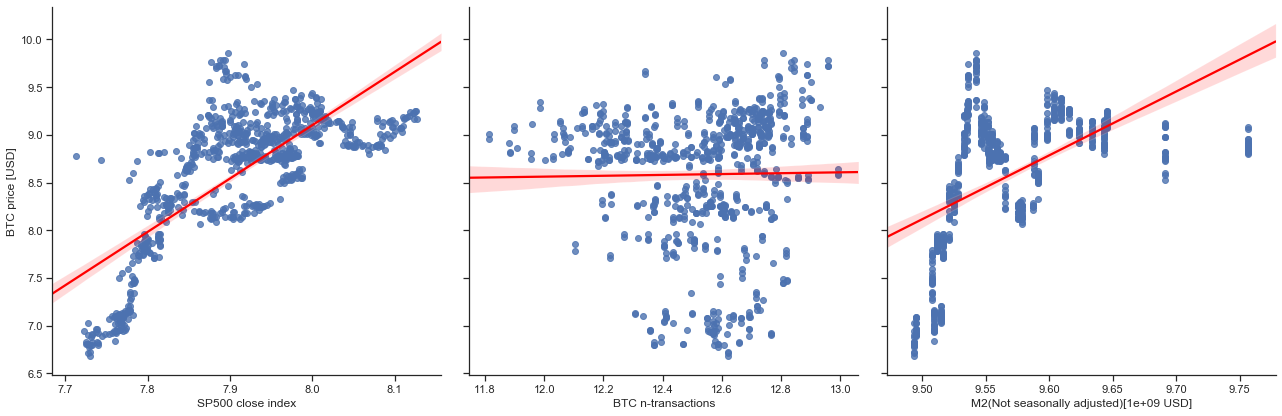

In [31]:
sns.set(style="ticks", color_codes=True)
for i in range(1,len(data2_log.columns),3):
    g = sns.PairGrid(data2_log,y_vars='BTC price [USD]',x_vars=data2_log.columns[i:i+3],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})

### Correlation matrices and VIF

In [32]:
def corr_matrix(dataset,dataname=' '):
    fig,ax = plt.subplots(figsize=(6,6))
    ax= sns.heatmap(dataset.corr(),vmin=0,vmax=1,annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title('correlation matrix for {}'.format(i))

def vif(dataset):
    X=dataset.drop(columns=['BTC price [USD]'])    
    X=sm.add_constant(X)
    return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns).iloc[1:]


VIF for  data
Volume BTC                                 1.123486
Gold price[USD]                            2.773815
Oil WTI price[USD]                         3.057275
SP500 close index                         12.415848
BTC n-transactions                         2.259505
M2(Not seasonally adjusted)[1e+09 USD]    11.380286
dtype: float64


variables with large VIF:
 SP500 close index                         12.415848
M2(Not seasonally adjusted)[1e+09 USD]    11.380286
dtype: float64
 

VIF for  data2
Volume BTC                                1.064071
Gold price[USD]                           3.658617
Oil WTI price[USD]                        4.385968
SP500 close index                         6.113458
BTC n-transactions                        1.290208
M2(Not seasonally adjusted)[1e+09 USD]    5.750483
dtype: float64


variables with large VIF:
 SP500 close index                         6.113458
M2(Not seasonally adjusted)[1e+09 USD]    5.750483
dtype: float64
 

VIF for  data2_log
Vol

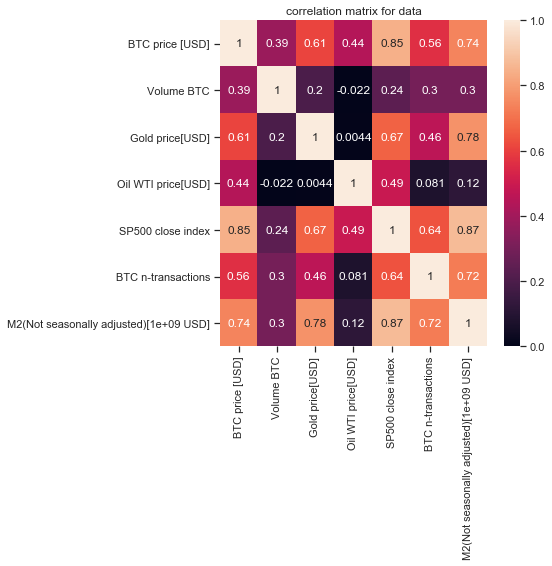

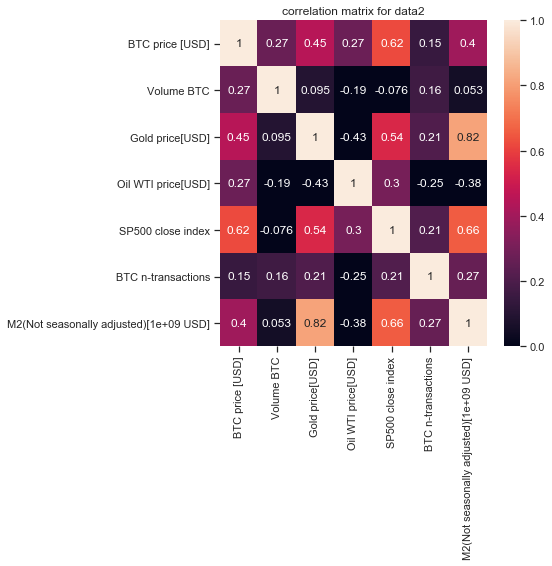

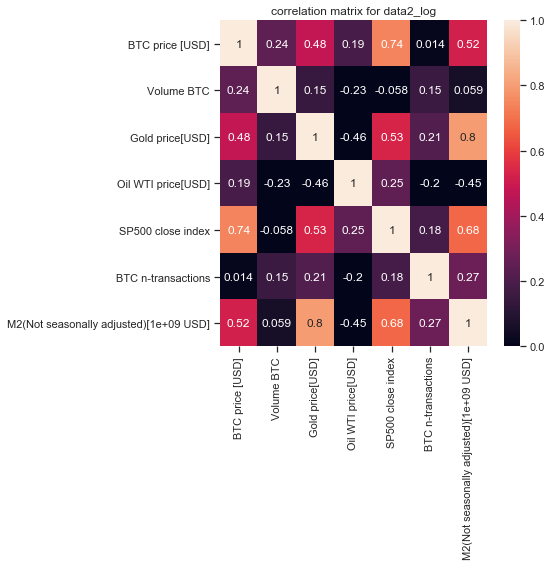

In [33]:
data_list=['data','data2','data2_log']
for i in data_list:
    print('\nVIF for ',i)
    ds=vif(eval(i))
    print(ds)
    print("\n")
    print('variables with large VIF:\n',ds[ds>5] )
    print(" ")
    corr_matrix(eval(i),i)



## The following variables are removed from the datasets:
### - data: M2
### - data2: SP500
### - data2_log: M2


## Graphical examination of correlation between independent variables (in log scale)

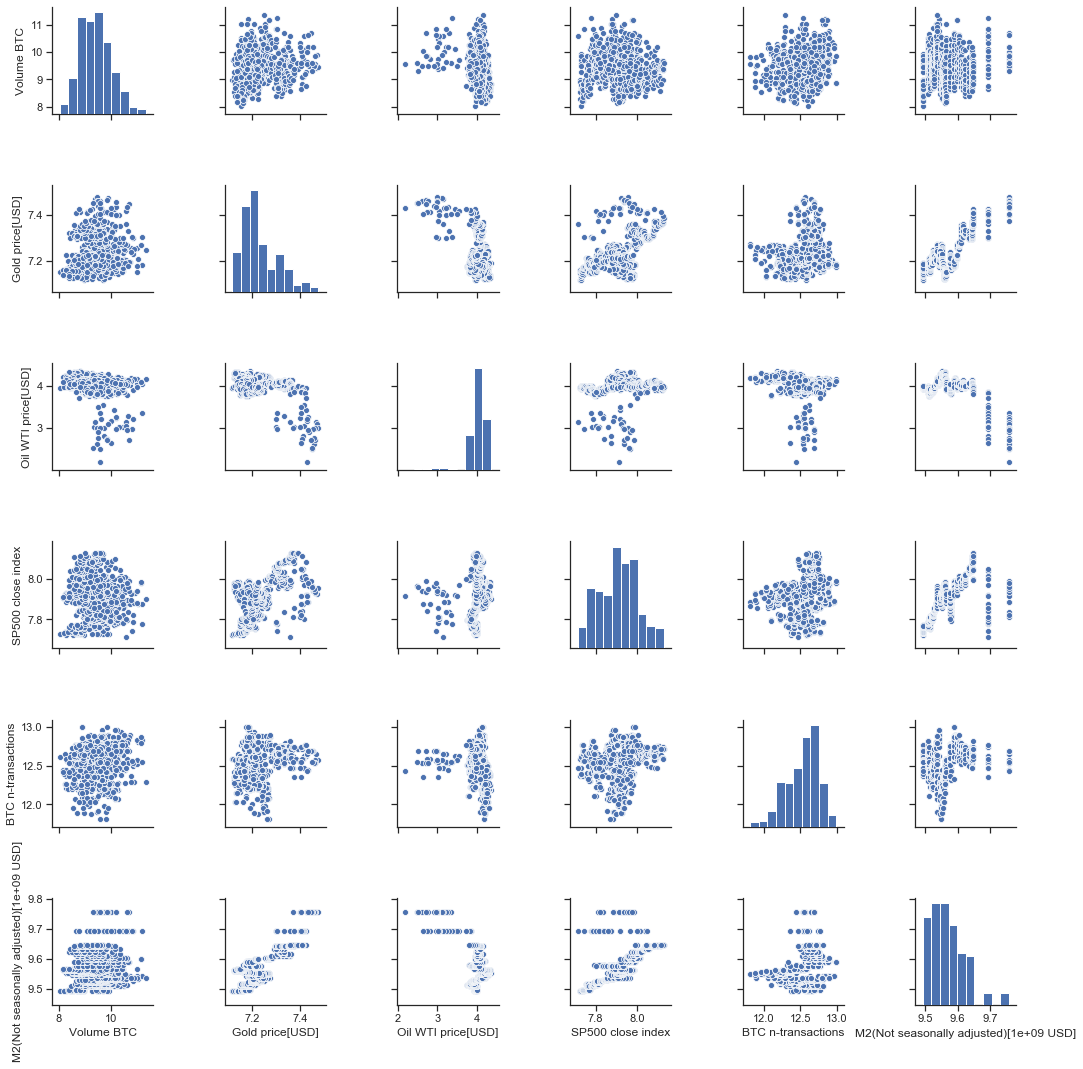

In [36]:
sns.pairplot(data2_log.drop(columns=['BTC price [USD]']))

In [37]:
data=data.drop(columns=['M2(Not seasonally adjusted)[1e+09 USD]'])
data2=data2.drop(columns=['SP500 close index'])
data2_log=data2_log.drop(columns=['M2(Not seasonally adjusted)[1e+09 USD]'])

# Multilinear regression models

### Models are build using the statsmodels library

## 1. Reg1 - Interval scale for the whole dataset ( _data_ )

In [38]:
y1=data['BTC price [USD]']
X1=data.drop(columns=['BTC price [USD]'])
X1=sm.add_constant(X1)
reg1=sm.OLS(y1,X1).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     872.4
Date:                Wed, 20 May 2020   Prob (F-statistic):               0.00
Time:                        17:49:43   Log-Likelihood:                -12119.
No. Observations:                1349   AIC:                         2.425e+04
Df Residuals:                    1343   BIC:                         2.428e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.281e+04    741.297    -30.766      0.000   -2.43e+04   -2.14e+04
Volume BTC             0.0720      0.005     14.587      0.000       0.062       0.082
Gold price[USD]        5.5004      0.714      7.699      0.000       4.099       6.902
Oil WTI price[USD]    55.5740      6.983      7.959      0.000      41.876      69.272
SP500 close index      6.2020      0.309     20.053      0.000       5.595       6.809
BTC n-transactions     0.0018      0.001      1.927      0.054   -3.19e-05       0.004
==============================================================================
Omnibus:                      534.671   Durbin-Watson:                   0.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3795.174
Skew:                           1.672   Prob(JB):                         0.00
Kurtosis:                      10.506   Cond. No.                     3.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2. Reg1a - Interval scale for the whole dataset ( _data_ ) without _BTC n-transactions_

In [39]:
y1a=data['BTC price [USD]']
X1a=data.drop(columns=['BTC price [USD]','BTC n-transactions'])
X1a=sm.add_constant(X1a)
reg1a=sm.OLS(y1a,X1a).fit()
reg1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1087.
Date:                Wed, 20 May 2020   Prob (F-statistic):               0.00
Time:                        17:49:43   Log-Likelihood:                -12121.
No. Observations:                1349   AIC:                         2.425e+04
Df Residuals:                    1344   BIC:                         2.428e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.273e+04    740.970    -30.676      0.000   -2.42e+04   -2.13e+04
Volume BTC             0.0733      0.005     15.009      0.000       0.064       0.083
Gold price[USD]        5.3112      0.708      7.498      0.000       3.922       6.701
Oil WTI price[USD]    50.8530      6.546      7.769      0.000      38.012      63.694
SP500 close index      6.5406      0.255     25.671      0.000       6.041       7.040
==============================================================================
Omnibus:                      565.610   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4388.059
Skew:                           1.758   Prob(JB):                         0.00
Kurtosis:                      11.106   Cond. No.                     2.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3. Reg2 - Interval scale for 2017-2020 ( _data2_ )

In [40]:
y2=data2['BTC price [USD]']
X2=data2.drop(columns='BTC price [USD]')
X2=sm.add_constant(X2)
reg2=sm.OLS(y2,X2).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     242.7
Date:                Wed, 20 May 2020   Prob (F-statistic):          1.64e-158
Time:                        17:49:43   Log-Likelihood:                -7444.7
No. Observations:                 819   AIC:                         1.490e+04
Df Residuals:                     813   BIC:                         1.493e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                  -4.132e+04   1671.151    -24.726      0.000   -4.46e+04    -3.8e+04
Volume BTC                                 0.1009      0.007     13.892      0.000       0.087       0.115
Gold price[USD]                           18.2635      1.229     14.855      0.000      15.850      20.677
Oil WTI price[USD]                       212.7336      8.125     26.182      0.000     196.785     228.683
BTC n-transactions                         0.0061      0.001      4.498      0.000       0.003       0.009
M2(Not seasonally adjusted)[1e+09 USD]     0.5112      0.163      3.139      0.002       0.192       0.831
==============================================================================
Omnibus:                      273.323   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1280.007
Skew:                           1.467   Prob(JB):                    1.12e-278
Kurtosis:                       8.376   Cond. No.                     6.46e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4. Logarithmic scale ( _data2_log_ )

In [41]:
y3=data2_log['BTC price [USD]']
X3=data2_log.drop(columns='BTC price [USD]')
X3=sm.add_constant(X3)
reg3=sm.OLS(y3,X3).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     342.3
Date:                Wed, 20 May 2020   Prob (F-statistic):          5.15e-197
Time:                        17:49:43   Log-Likelihood:                -406.35
No. Observations:                 817   AIC:                             824.7
Df Residuals:                     811   BIC:                             852.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -41.8642      1.771    -23.639      0.000     -45.340     -38.388
Volume BTC             0.3708      0.024     15.170      0.000       0.323       0.419
Gold price[USD]        1.8516      0.317      5.832      0.000       1.228       2.475
Oil WTI price[USD]     0.4455      0.085      5.264      0.000       0.279       0.612
SP500 close index      4.8402      0.242     20.027      0.000       4.366       5.315
BTC n-transactions    -0.5179      0.068     -7.636      0.000      -0.651      -0.385
==============================================================================
Omnibus:                        6.513   Durbin-Watson:                   0.221
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.429
Skew:                           0.192   Prob(JB):                       0.0402
Kurtosis:                       3.203   Cond. No.                     2.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Standard error and error plots for regressions

$$ RSS = ( y_1 - \hat{y_1})^2 + ... + ( y_n - \hat{y_n})^2 $$
$$ RSE = \sqrt{\frac{RSS}{n-p-1}} $$
where: <br>
RSS (resudual sum of squares) - difference between the _i-th_ observed response value and the _i-th_ response value that is predicted <br>
RSE (residual standard error) - a measure of lack of fit of the model <br>
_p_ (degrees of freedom) - number of estimated parameters WITHOUT intercept <br>
_n_ - number of observations

In [42]:
def RSE(regression_model,y_true,X):
    p=X.shape[1]
    y_predicted=regression_model.predict(X)
    rss=((y_true-y_predicted)**2).sum()
    rse=np.sqrt(rss/(y_true.shape[0]-p))
    return rse

def error_plots(regression_model,y_true,X,name='regression'):
    y_predicted=regression_model.predict(X)
    fig,ax = plt.subplots(ncols=2,figsize=(14,6))
    residuals=(-y_predicted+y_true)
    ax[0].scatter(y_predicted,residuals)
    ax[0].set_xlabel('y predicted')
    ax[0].set_ylabel('residuals')
    ax[0].set_title('Residual plot for the {} model'.format(name))
    
    r=probplot(residuals,dist='norm', fit=True, plot=ax[1])
    ax[1].set_title('Probability plot of residuals against the quantiles for the {} model'.format(name))

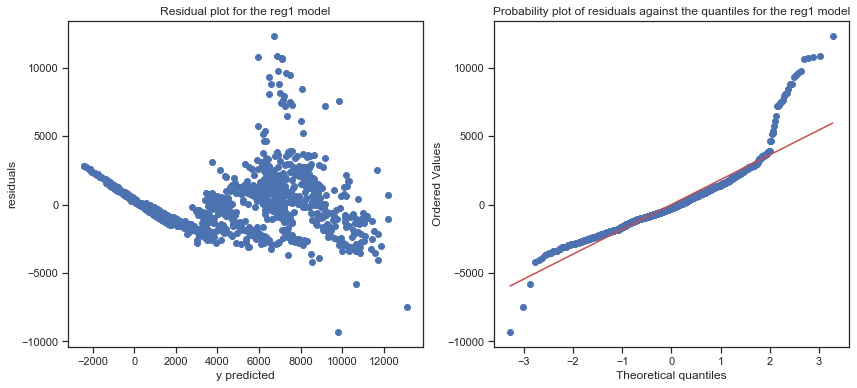

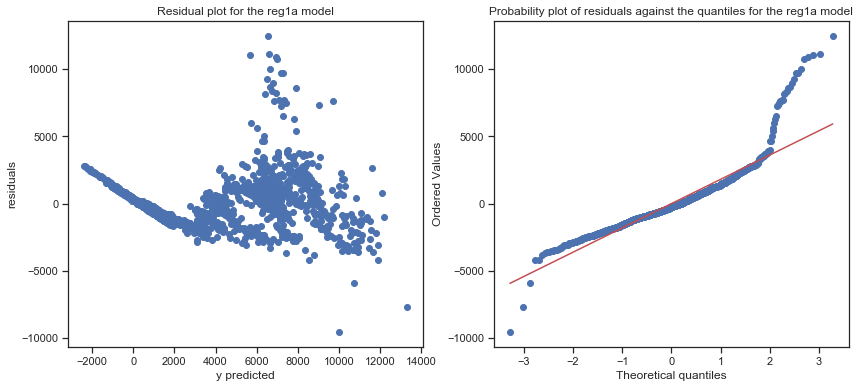

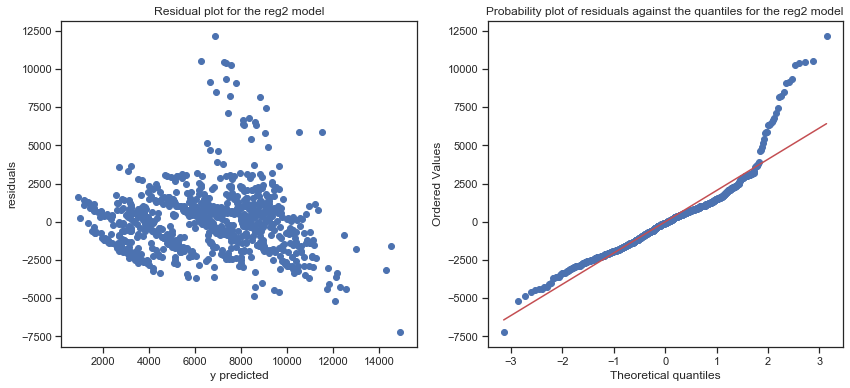

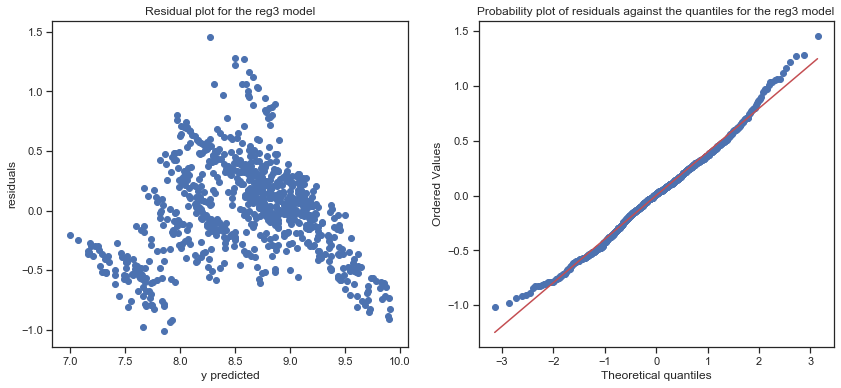

In [45]:
reg_list=['reg1','reg1a','reg2','reg3']
summary_df=pd.DataFrame(columns=['R-squared','F-statistic','RSE'])

for i,j,k in zip(reg_list,[X1,X1a,X2,X3],[y1,y1a,y2,y3]):
    rse=RSE(eval(i),k,j)
    f=eval(i).fvalue
    r=eval(i).rsquared
    summary_df = summary_df.append(
                {'R-squared': r, 
                 'F-statistic': f, 
                 'RSE': rse,}, 
                ignore_index=True)
    error_plots(eval(i),k,j,i)
summary_df.index=reg_list

In [46]:
summary_df

,R-squared,F-statistic,RSE
reg1,0.764595,872.411680,1933.275017
reg1a,0.763944,1087.389289,1935.226684
reg2,0.598826,242.710639,2153.176125
reg3,0.678479,342.276837,0.399362


### Conclusion:
- Each model is wrong. In every residual plot a strong pattern is noticable what indicates non-linearity in the data
- In each probabilty plot of residual a nonlinear pattern is noticable as well.
- _reg1a_ is the best model from the received (taking R-squared and F-statistic into account). However, the author does not recommend to use it.

### In the future the autor will introduce some nonlinear terms to the model